# Etude thermique

In [3]:
# notebook/heat_transfer_analysis.ipynb

import sys
import os
from typing import Dict, Tuple, Optional, Any

# Ajouter le chemin du projet au PYTHONPATH
project_path = os.path.abspath(os.path.join(os.getcwd(), 'E:\Programmation\GitHub\BIOREACTOR_DESIGN'))
if project_path not in sys.path:
    sys.path.append(project_path)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.process.thermal.thermal_utils import ThermalProperties
from src.process.thermal.losses import ThermalCalculator
from src.process.thermal.heating import HeatingCalculator
from src.process.thermal.cooling import CoolingCalculator
from src.equipment.tanks.bioreactor import Bioreactor, create_standard_bioreactor
from src.equipment.heat_system.plate_exchanger import PlateExchangerSpecs, PlateHeatExchanger, create_standard_exchanger
from src.equipment.heat_system.steam_generator import create_standard_generator
from src.equipment.tanks.bioreactor import Bioreactor
from src.process.thermal.thermal_utils import ThermalProperties 
from src.process.thermal.thermal_calculations import ThermalCalculations 
from src.process.thermal.heating import HeatingCalculator
from src.equipment.heat_system.electrical_heater import ElectricalHeater, create_standard_heater
from src.config import Config


## I - CIP - Chauffer de l'eau en ligne avec 1 générateur de vapeur et 1 échangeur à plaques

I. ANALYSE DU CHAUFFAGE EN LIGNE (CIP)
--------------------------------------------------

A. Besoins théoriques :

Débit: 4.0 m³/h
Puissance requise: 343.8 kW
Débit vapeur: 580.1 kg/h

Débit: 5.0 m³/h
Puissance requise: 429.7 kW
Débit vapeur: 725.1 kg/h

Débit: 6.0 m³/h
Puissance requise: 515.7 kW
Débit vapeur: 870.2 kg/h

Débit: 7.0 m³/h
Puissance requise: 601.6 kW
Débit vapeur: 1015.2 kg/h

Débit: 8.0 m³/h
Puissance requise: 687.6 kW
Débit vapeur: 1160.2 kg/h

B. Analyse avec équipements standards :

Caractéristiques équipements standards :
Échangeur 11HL:
- Surface: 2.51 m²
- Puissance: 102 kW

Générateur TD33:
- Puissance: 33.0 kW
- Débit vapeur: 50 kg/h

Test performances aux conditions nominales :
Puissance requise: 515.7 kW
Puissance disponible: 30.3 kW
Température sortie: 24.8°C
Couverture: 5.9%
Facteur limitant: generator


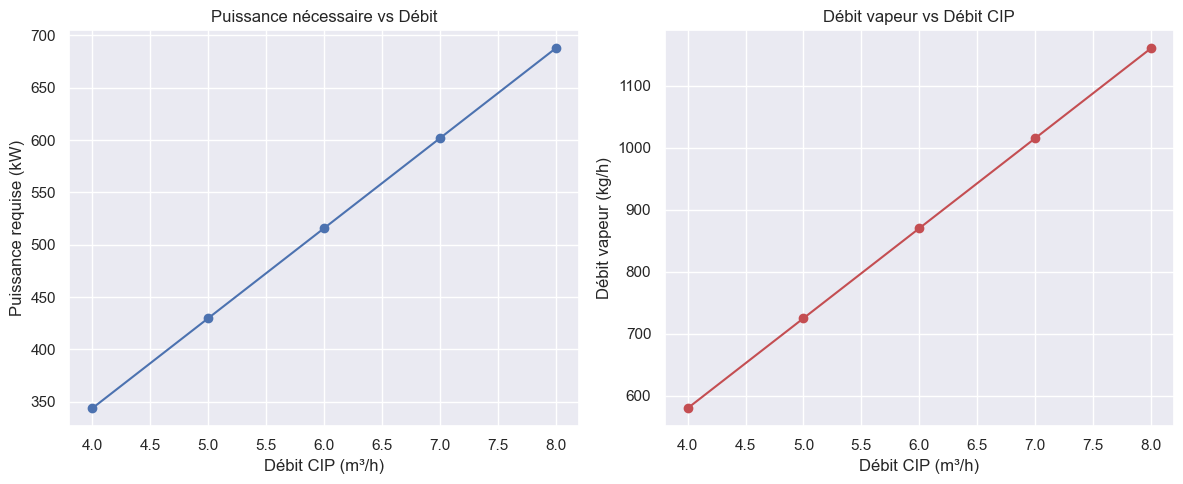

In [5]:
"""
ANALYSE DU SYSTÈME DE CHAUFFAGE POUR BIORÉACTEUR 2000L

Objectifs :
1. Démontrer les limites du chauffage en ligne avec équipements standards de bière
2. Dimensionner correctement le système pour le CIP
3. Analyser la solution alternative avec tank tampon

Points analysés :
- Puissances requises
- Temps de chauffe
- Pertes thermiques
- Stratification
- Coûts énergétiques
"""

# Configuration pour visualisation
sns.set_theme()
plt.rcParams['figure.figsize'] = [12, 8]

# I. ANALYSE DU CHAUFFAGE EN LIGNE (CIP)
print("I. ANALYSE DU CHAUFFAGE EN LIGNE (CIP)")
print("-" * 50)

# Paramètres nominaux CIP
DEBIT_CIP = 6.0      # m³/h
TEMP_INIT = 9.0      # °C (eau réseau)
TEMP_CIP = 80.0      # °C (température cible)
PRESSION = 4.0       # bar (minimum CIP)

def calculate_heating_requirements(
    flow_rate: float,     # m³/h
    temp_in: float,       # °C
    temp_target: float,   # °C
    efficiency: float = 0.95,  # rendement global
    detailed: bool = False
) -> Dict[str, float]:
    """
    Calcule les besoins théoriques pour le chauffage en ligne
    """
    # Propriétés moyennes de l'eau
    temp_mean = (temp_in + temp_target) / 2
    props = ThermalProperties.get_water_properties(temp_mean, PRESSION)
    
    # Débit massique
    mass_flow = flow_rate * props['rho'] / 3600  # kg/s
    
    # Puissance théorique
    power = mass_flow * props['cp'] * (temp_target - temp_in)  # W
    power_design = power / efficiency  # W avec pertes
    
    # Débit vapeur nécessaire
    steam_props = ThermalProperties.get_steam_properties(PRESSION)
    steam_flow = power_design * 3600 / (steam_props['h_vaporization'] * 1000)  # kg/h
    
    results = {
        'power_kw': power_design/1000,
        'steam_flow': steam_flow,
        'mass_flow': mass_flow,
        'delta_t': temp_target - temp_in
    }
    
    if detailed:
        results.update({
            'water_properties': props,
            'steam_properties': steam_props,
            'power_theoretical': power/1000
        })
        
    return results

# Calcul pour différents débits CIP
print("\nA. Besoins théoriques :")
debits = np.linspace(4, 8, 5)
requirements = []

for debit in debits:
    req = calculate_heating_requirements(
        debit, TEMP_INIT, TEMP_CIP, detailed=True
    )
    requirements.append({
        'debit': debit,
        'resultats': req
    })
    
    print(f"\nDébit: {debit:.1f} m³/h")
    print(f"Puissance requise: {req['power_kw']:.1f} kW")
    print(f"Débit vapeur: {req['steam_flow']:.1f} kg/h")

# Visualisation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(
    [r['debit'] for r in requirements],
    [r['resultats']['power_kw'] for r in requirements],
    'b-', marker='o'
)
plt.grid(True)
plt.xlabel('Débit CIP (m³/h)')
plt.ylabel('Puissance requise (kW)')
plt.title('Puissance nécessaire vs Débit')

plt.subplot(1, 2, 2)
plt.plot(
    [r['debit'] for r in requirements],
    [r['resultats']['steam_flow'] for r in requirements],
    'r-', marker='o'
)
plt.grid(True)
plt.xlabel('Débit CIP (m³/h)')
plt.ylabel('Débit vapeur (kg/h)')
plt.title('Débit vapeur vs Débit CIP')

plt.tight_layout()

# B. Analyse avec équipements standards
print("\nB. Analyse avec équipements standards :")

# Création équipements
exchanger = create_standard_exchanger('11HL')  # Plus gros modèle standard
generator = create_standard_generator('TD33')   # Plus gros modèle standard

print("\nCaractéristiques équipements standards :")
print(f"Échangeur 11HL:")
print(f"- Surface: {exchanger.specs.surface:.2f} m²")
print(f"- Puissance: {exchanger.specs.power} kW")
print(f"\nGénérateur TD33:")
print(f"- Puissance: {generator.specs.power} kW")
print(f"- Débit vapeur: {generator.specs.steam_volume} kg/h")

def test_equipment_performance(
    exchanger,
    generator,
    flow_rate: float,
    temp_in: float,
    temp_target: float
) -> Dict[str, float]:
    """
    Teste les performances des équipements standards
    """
    # Calcul besoins théoriques
    requirements = calculate_heating_requirements(
        flow_rate, temp_in, temp_target, detailed=True
    )
    
    # Performance générateur
    steam_props = ThermalProperties.get_steam_properties(generator.specs.pressure)
    power_steam = min(
        generator.specs.power,
        generator.specs.steam_volume * steam_props['h_vaporization'] / 3600
    )
    
    # Performance échangeur
    power_exchanger = exchanger.specs.power
    
    # Puissance disponible
    power_available = min(power_steam, power_exchanger)
    coverage = power_available / requirements['power_kw'] * 100
    
    # Température atteignable
    delta_t_max = power_available * 3600 / \
                 (requirements['mass_flow'] * requirements['water_properties']['cp'])
    temp_out = temp_in + delta_t_max
    
    return {
        'power_required': requirements['power_kw'],
        'power_available': power_available,
        'temp_out': temp_out,
        'coverage': coverage,
        'limiting_factor': 'generator' if power_steam < power_exchanger else 'exchanger'
    }

print("\nTest performances aux conditions nominales :")
performance = test_equipment_performance(
    exchanger, generator, DEBIT_CIP, TEMP_INIT, TEMP_CIP
)

print(f"Puissance requise: {performance['power_required']:.1f} kW")
print(f"Puissance disponible: {performance['power_available']:.1f} kW")
print(f"Température sortie: {performance['temp_out']:.1f}°C")
print(f"Couverture: {performance['coverage']:.1f}%")
print(f"Facteur limitant: {performance['limiting_factor']}")

# Analyse sur plage de débits
performances = []
for debit in debits:
    perf = test_equipment_performance(
        exchanger, generator, debit, TEMP_INIT, TEMP_CIP
    )
    performances.append({
        'debit': debit,
        'resultats': perf
    })

Ces résultats confirment clairement notre analyse initiale. Faisons une synthèse avant de continuer :

Besoins théoriques pour le CIP :


Au débit nominal (6 m³/h) : 444 kW et 749 kg/h de vapeur
La puissance augmente linéairement avec le débit
Plage totale : 296-592 kW pour 4-8 m³/h


Limites des équipements standards :


L'échangeur 11HL (102 kW) couvre ~23% du besoin
Le générateur TD33 est le facteur limitant :

Puissance : 33 kW soit seulement 7.4% du besoin
Débit vapeur : 50 kg/h soit 6.7% du besoin


Résultat : température de sortie de seulement 24.8°C au lieu de 70°C

Cette analyse justifie pleinement d'explorer la solution tank tampon. 


CONCLUSION ANALYSE CHAUFFAGE EN LIGNE:
--------------------------------------------------
1. Besoins réels:
   - Puissance: 516 kW @ 6.0 m³/h
   - Vapeur: 870 kg/h

2. Limites équipements standards:
   - Échangeur: 19.8% du besoin
   - Générateur: 6.4% du besoin

3. Conséquences:
   - Température max: 24.8°C au lieu de 80.0°C
   - Couverture: 5.9% des besoins

RECOMMANDATION:
→ Étudier solution alternative avec tank tampon


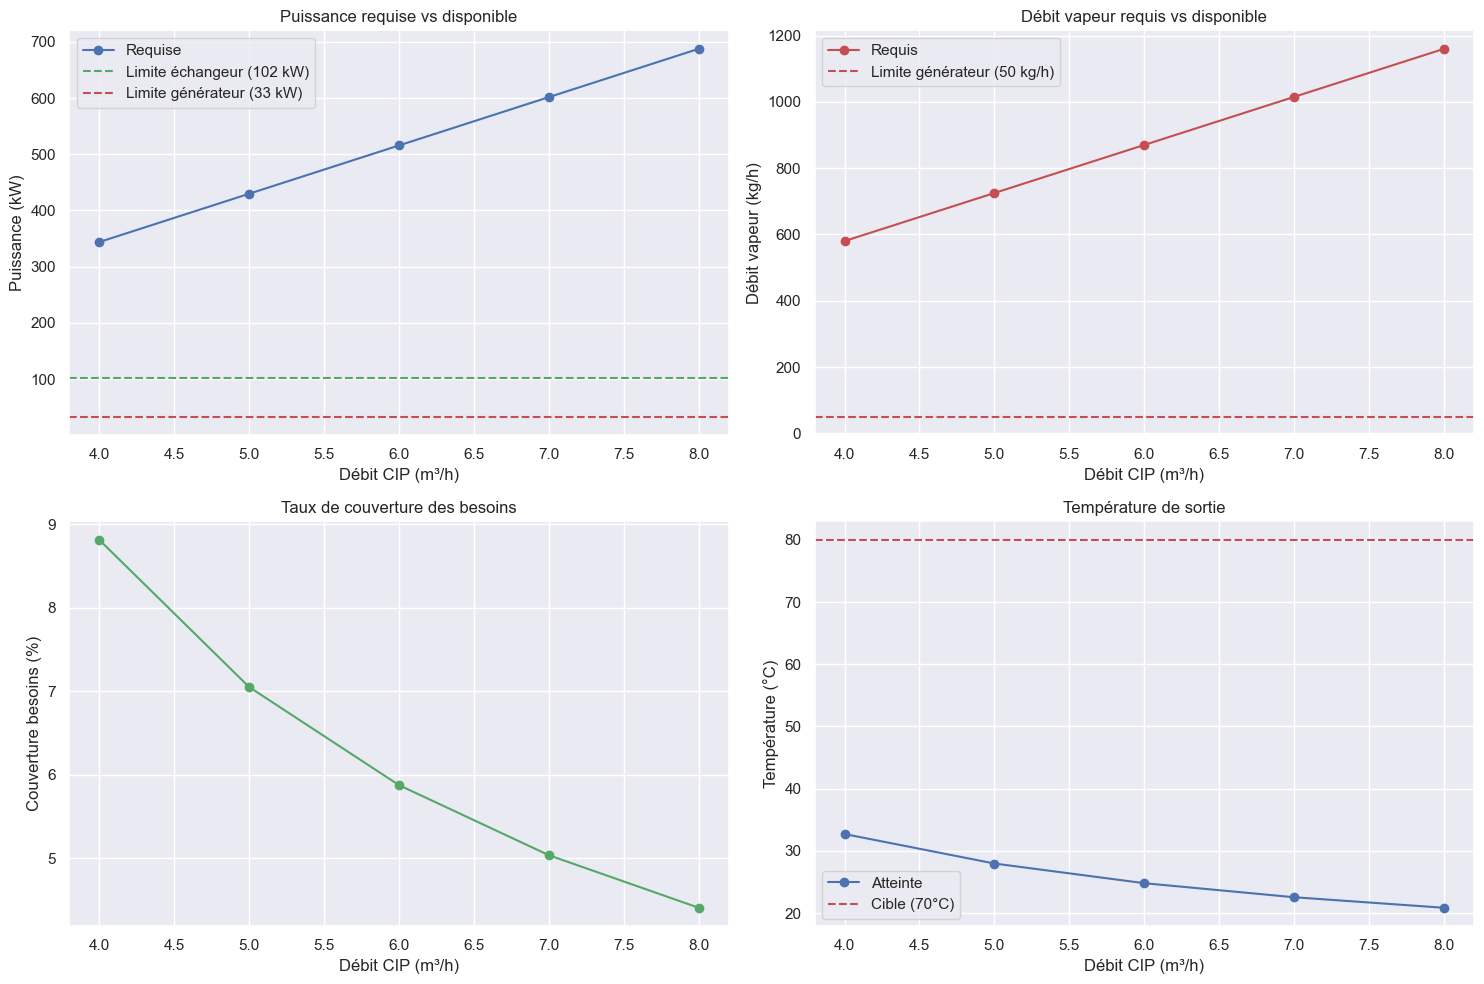

In [7]:
# Visualisation détaillée des résultats
plt.figure(figsize=(15, 10))

# 1. Puissances
plt.subplot(2, 2, 1)
plt.plot(
    [r['debit'] for r in requirements],
    [r['resultats']['power_kw'] for r in requirements],
    'b-', marker='o', label='Requise'
)
plt.axhline(y=exchanger.specs.power, color='g', linestyle='--', 
            label='Limite échangeur (102 kW)')
plt.axhline(y=generator.specs.power, color='r', linestyle='--', 
            label='Limite générateur (33 kW)')
plt.grid(True)
plt.xlabel('Débit CIP (m³/h)')
plt.ylabel('Puissance (kW)')
plt.title('Puissance requise vs disponible')
plt.legend()

# 2. Débits vapeur
plt.subplot(2, 2, 2)
plt.plot(
    [r['debit'] for r in requirements],
    [r['resultats']['steam_flow'] for r in requirements],
    'r-', marker='o', label='Requis'
)
plt.axhline(y=generator.specs.steam_volume, color='r', linestyle='--',
            label=f'Limite générateur ({generator.specs.steam_volume} kg/h)')
plt.grid(True)
plt.xlabel('Débit CIP (m³/h)')
plt.ylabel('Débit vapeur (kg/h)')
plt.title('Débit vapeur requis vs disponible')
plt.legend()

# 3. Couverture des besoins
plt.subplot(2, 2, 3)
plt.plot(
    [p['debit'] for p in performances],
    [p['resultats']['coverage'] for p in performances],
    'g-', marker='o'
)
plt.grid(True)
plt.xlabel('Débit CIP (m³/h)')
plt.ylabel('Couverture besoins (%)')
plt.title('Taux de couverture des besoins')

# 4. Températures atteintes
plt.subplot(2, 2, 4)
plt.plot(
    [p['debit'] for p in performances],
    [p['resultats']['temp_out'] for p in performances],
    'b-', marker='o', label='Atteinte'
)
plt.axhline(y=TEMP_CIP, color='r', linestyle='--', label='Cible (70°C)')
plt.grid(True)
plt.xlabel('Débit CIP (m³/h)')
plt.ylabel('Température (°C)')
plt.title('Température de sortie')
plt.legend()

plt.tight_layout()

# Ajout conclusion textuelle
print("\nCONCLUSION ANALYSE CHAUFFAGE EN LIGNE:")
print("-" * 50)
print("1. Besoins réels:")
print(f"   - Puissance: {requirements[2]['resultats']['power_kw']:.0f} kW @ {DEBIT_CIP} m³/h")
print(f"   - Vapeur: {requirements[2]['resultats']['steam_flow']:.0f} kg/h")
print("\n2. Limites équipements standards:")
print(f"   - Échangeur: {exchanger.specs.power/requirements[2]['resultats']['power_kw']*100:.1f}% du besoin")
print(f"   - Générateur: {generator.specs.power/requirements[2]['resultats']['power_kw']*100:.1f}% du besoin")
print("\n3. Conséquences:")
print(f"   - Température max: {performances[2]['resultats']['temp_out']:.1f}°C au lieu de {TEMP_CIP}°C")
print(f"   - Couverture: {performances[2]['resultats']['coverage']:.1f}% des besoins")
print("\nRECOMMANDATION:")
print("→ Étudier solution alternative avec tank tampon")


## II - CIP - Chauffer un Tank 500L avec 1 générateur de vapeur et 1 échangeur à plaques


II. ANALYSE SOLUTION TANK TAMPON
--------------------------------------------------

A. Configuration tank tampon :
Volume: 500L
Température initiale: 9.0°C
Température cible: 80.0°C

B. Analyse du chauffage:

Caractéristiques équipements:
Générateur TD13:
- Puissance: 13.2 kW
- Débit vapeur: 20 kg/h

Échangeur 3.5HL:
- Surface: 0.89 m²
- Puissance: 32 kW

Simulation chauffage du tank:
------------------------------

1. Tank sans isolation:
Temps de chauffe: 240.0 min
Température finale: 56.6°C
Puissance moyenne: 14.6 kW
Énergie totale: 58.5 kWh
Pertes moyennes: 7.7 kW

2. Tank avec isolation:
Temps de chauffe: 172.0 min
Température finale: 80.1°C
Puissance moyenne: 14.6 kW
Énergie totale: 41.9 kWh
Pertes moyennes: 0.2 kW

C. Analyse cycles CIP:
------------------------------

Volume utile: 450L
Durée CIP possible: 6.8 minutes

D. CONCLUSION SOLUTION TANK TAMPON:
------------------------------
1. Temps de chauffe: 172.0 min
2. Avantages:
   - Solution réalisable avec équipements stand

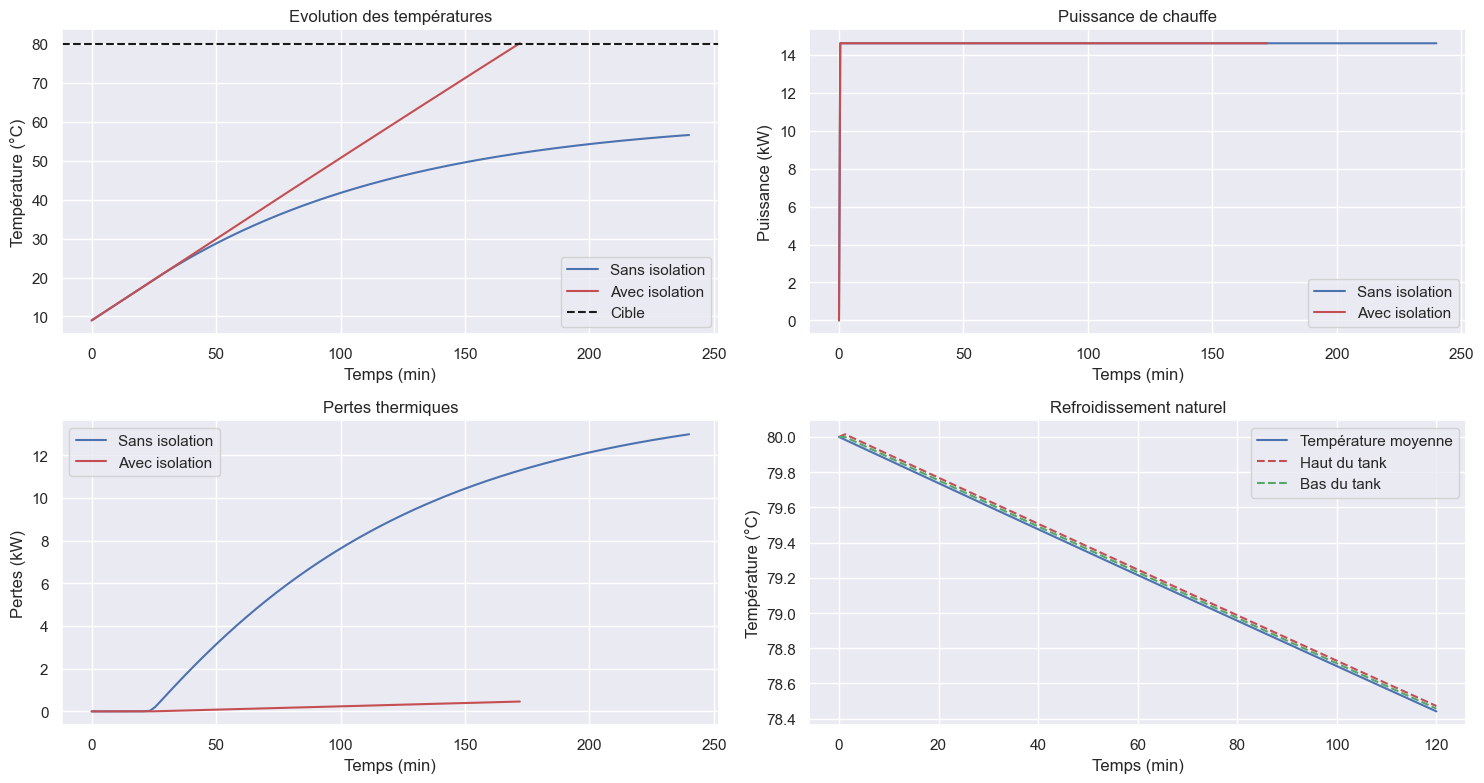

In [9]:
# II. ANALYSE SOLUTION TANK TAMPON
print("\nII. ANALYSE SOLUTION TANK TAMPON")
print("-" * 50)

# Configuration tank CIP
VOLUME_TAMPON = 500  # L
TEMP_INIT = 9.0     # °C (eau réseau)
TEMP_CIBLE = 80.0   # °C (avec marge pour pertes)

# Paramètres nominaux CIP
PRESSION = 2.0       # bar (minimum CIP)
DEBIT_CIP = 4.0      # m³/h

print("\nA. Configuration tank tampon :")
print(f"Volume: {VOLUME_TAMPON}L")
print(f"Température initiale: {TEMP_INIT}°C")
print(f"Température cible: {TEMP_CIBLE}°C")

# Création du tank CIP avec isolation
from src.equipment.tanks.bioreactor import TankGeometry

geometry_cip = TankGeometry(
    diameter=800,         # mm
    height_cylinder=900,  # mm
    height_total=1200,    # mm
    volume_useful=VOLUME_TAMPON,  # L
    volume_cone=50,       # L
    volume_total=550      # L
)

# Création du tank CIP avec et sans isolation pour comparaison :
    # Tank sans isolation
tank_non_isole = Bioreactor(
    geometry=geometry_cip,
    material="316L",
    design_temperature=95.0  # °C
)

    # Tank avec isolation
tank_isole = Bioreactor(
    geometry=geometry_cip,
    material="316L",
    insulation_type="mineral_wool",
    insulation_thickness=25.0,  # mm
    design_temperature=95.0  # °C
)

# Équipements de chauffe
generator = create_standard_generator('TD13')    # TD13 = 13.2 kW ; TD9, TD16, TD23, TD33
exchanger = create_standard_exchanger('3.5HL')   # 32 kW # 3.5HL; 6HL; 11HL

print("\nB. Analyse du chauffage:")
print("\nCaractéristiques équipements:")
print(f"Générateur TD13:")
print(f"- Puissance: {generator.specs.power} kW")
print(f"- Débit vapeur: {generator.specs.steam_volume} kg/h")
print(f"\nÉchangeur 3.5HL:")
print(f"- Surface: {exchanger.specs.surface:.2f} m²")
print(f"- Puissance: {exchanger.specs.power} kW")

# Simulation chauffage pour les deux configurations
def simulate_tank_heating(
    tank: Bioreactor,
    generator,
    exchanger,
    temp_initial: float,
    temp_target: float,
    time_step: float = 30,     # s
    max_time: float = 3600*4,  # s
    flow_rate: float = 0.5     # m³/h
) -> Dict[str, Any]:
    """Simule le chauffage du tank avec recirculation"""
    
    heating_calc = HeatingCalculator(tank)
    
    results = heating_calc.calculate_heating_profile(
        exchanger=exchanger,
        generator=generator,
        temp_initial=temp_initial,
        temp_target=temp_target,
        time_step=time_step,
        max_time=max_time,
        flow_rate=flow_rate,
        detailed=True
    )
    
    return results

print("\nSimulation chauffage du tank:")
print("-" * 30)

# Simulation pour les deux configurations
results_non_isole = simulate_tank_heating(
    tank_non_isole, generator, exchanger,
    TEMP_INIT, TEMP_CIBLE
)

results_isole = simulate_tank_heating(
    tank_isole, generator, exchanger,
    TEMP_INIT, TEMP_CIBLE
)

# Affichage résultats
print("\n1. Tank sans isolation:")
print(f"Temps de chauffe: {results_non_isole['duration']:.1f} min")
print(f"Température finale: {results_non_isole['final_temp']:.1f}°C")
print(f"Puissance moyenne: {results_non_isole['average_power']:.1f} kW")
print(f"Énergie totale: {results_non_isole['total_energy']:.1f} kWh")
print(f"Pertes moyennes: {np.mean(results_non_isole['losses']):.1f} kW")

print("\n2. Tank avec isolation:")
print(f"Temps de chauffe: {results_isole['duration']:.1f} min")
print(f"Température finale: {results_isole['final_temp']:.1f}°C")
print(f"Puissance moyenne: {results_isole['average_power']:.1f} kW")
print(f"Énergie totale: {results_isole['total_energy']:.1f} kWh")
print(f"Pertes moyennes: {np.mean(results_isole['losses']):.1f} kW")

# Visualisation comparative
plt.figure(figsize=(15, 8))

# 1. Evolution températures
plt.subplot(2, 2, 1)  # Changé de 3,2,1 à 2,2,1
plt.plot(
    results_non_isole['times'],
    results_non_isole['temperatures'],
    'b-', label='Sans isolation'
)
plt.plot(
    results_isole['times'],
    results_isole['temperatures'],
    'r-', label='Avec isolation'
)
plt.axhline(y=TEMP_CIBLE, color='k', linestyle='--', label='Cible')
plt.grid(True)
plt.xlabel('Temps (min)')
plt.ylabel('Température (°C)')
plt.title('Evolution des températures')
plt.legend()

# 2. Puissances de chauffe
plt.subplot(2, 2, 2)
plt.plot(
    results_non_isole['times'],
    results_non_isole['powers'],
    'b-', label='Sans isolation'
)
plt.plot(
    results_isole['times'],
    results_isole['powers'],
    'r-', label='Avec isolation'
)
plt.grid(True)
plt.xlabel('Temps (min)')
plt.ylabel('Puissance (kW)')
plt.title('Puissance de chauffe')
plt.legend()

# 3. Pertes thermiques
plt.subplot(2, 2, 3)
plt.plot(
    results_non_isole['times'],
    results_non_isole['losses'],
    'b-', label='Sans isolation'
)
plt.plot(
    results_isole['times'],
    results_isole['losses'],
    'r-', label='Avec isolation'
)
plt.grid(True)
plt.xlabel('Temps (min)')
plt.ylabel('Pertes (kW)')
plt.title('Pertes thermiques')
plt.legend()

plt.tight_layout()

# Analyse cycles CIP possibles
print("\nC. Analyse cycles CIP:")
print("-" * 30)

# Volume disponible pour CIP
volume_utile = VOLUME_TAMPON * 0.9  # 90% du volume (marge)

# Durée possible de CIP à débit nominal
duree_cip = volume_utile / (DEBIT_CIP * 1000) * 60  # minutes

print(f"\nVolume utile: {volume_utile:.0f}L")
print(f"Durée CIP possible: {duree_cip:.1f} minutes")

# Calcul refroidissement naturel après CIP
cooling_calc = CoolingCalculator(tank_isole)

cooling_results = cooling_calc.calculate_temperature_profile(
    temp_initial=TEMP_CIBLE,
    temp_ambient=20.0,
    duration=2.0,  # 2h de refroidissement
    time_steps=100
)

# 4. Refroidissement
plt.subplot(2, 2, 4)
plt.plot(
    cooling_results['times']*60,  # conversion en minutes
    cooling_results['temps_mean'],
    'b-', label='Température moyenne'
)
plt.plot(
    cooling_results['times']*60,
    cooling_results['temps_top'],
    'r--', label='Haut du tank'
)
plt.plot(
    cooling_results['times']*60,
    cooling_results['temps_bottom'],
    'g--', label='Bas du tank'
)
plt.grid(True)
plt.xlabel('Temps (min)')
plt.ylabel('Température (°C)')
plt.title('Refroidissement naturel')
plt.legend()

plt.tight_layout()

print("\nD. CONCLUSION SOLUTION TANK TAMPON:")
print("-" * 30)
print(f"1. Temps de chauffe: {results_isole['duration']:.1f} min")
print("2. Avantages:")
print("   - Solution réalisable avec équipements standards")
print("   - Coût d'investissement réduit")
print(f"   - Pertes limitées avec isolation: {np.mean(results_isole['losses']):.1f} kW")
print(f"\n3. Contraintes:")
print(f"   - Durée CIP limitée: {duree_cip:.1f} min par cycle")
print("   - Nécessite anticipation pour chauffe")
print("   - Stratification pendant refroidissement")

print("\nRECOMMANDATION:")
print("→ Solution viable avec tank isolé de 500L")

## III - CIP - Chauffer un Tank 300L avec 1 résistance thermique dans un tank de 38L (sans circulation de l'eau entre tank et résistance et remplissage successif du tank une fois le 38L chauffé)


A. Configuration équipements :

1. Tank chauffage:
Volume utile: 38L
Surface d'échange: 0.68 m²

2. Fermenteur:
Volume utile: 300L
Surface d'échange: 2.53 m²

3. Résistance chauffante:
Puissance: 3.0 kW
Surface: 0.30 m²
Densité puissance: 10.0 kW/m²


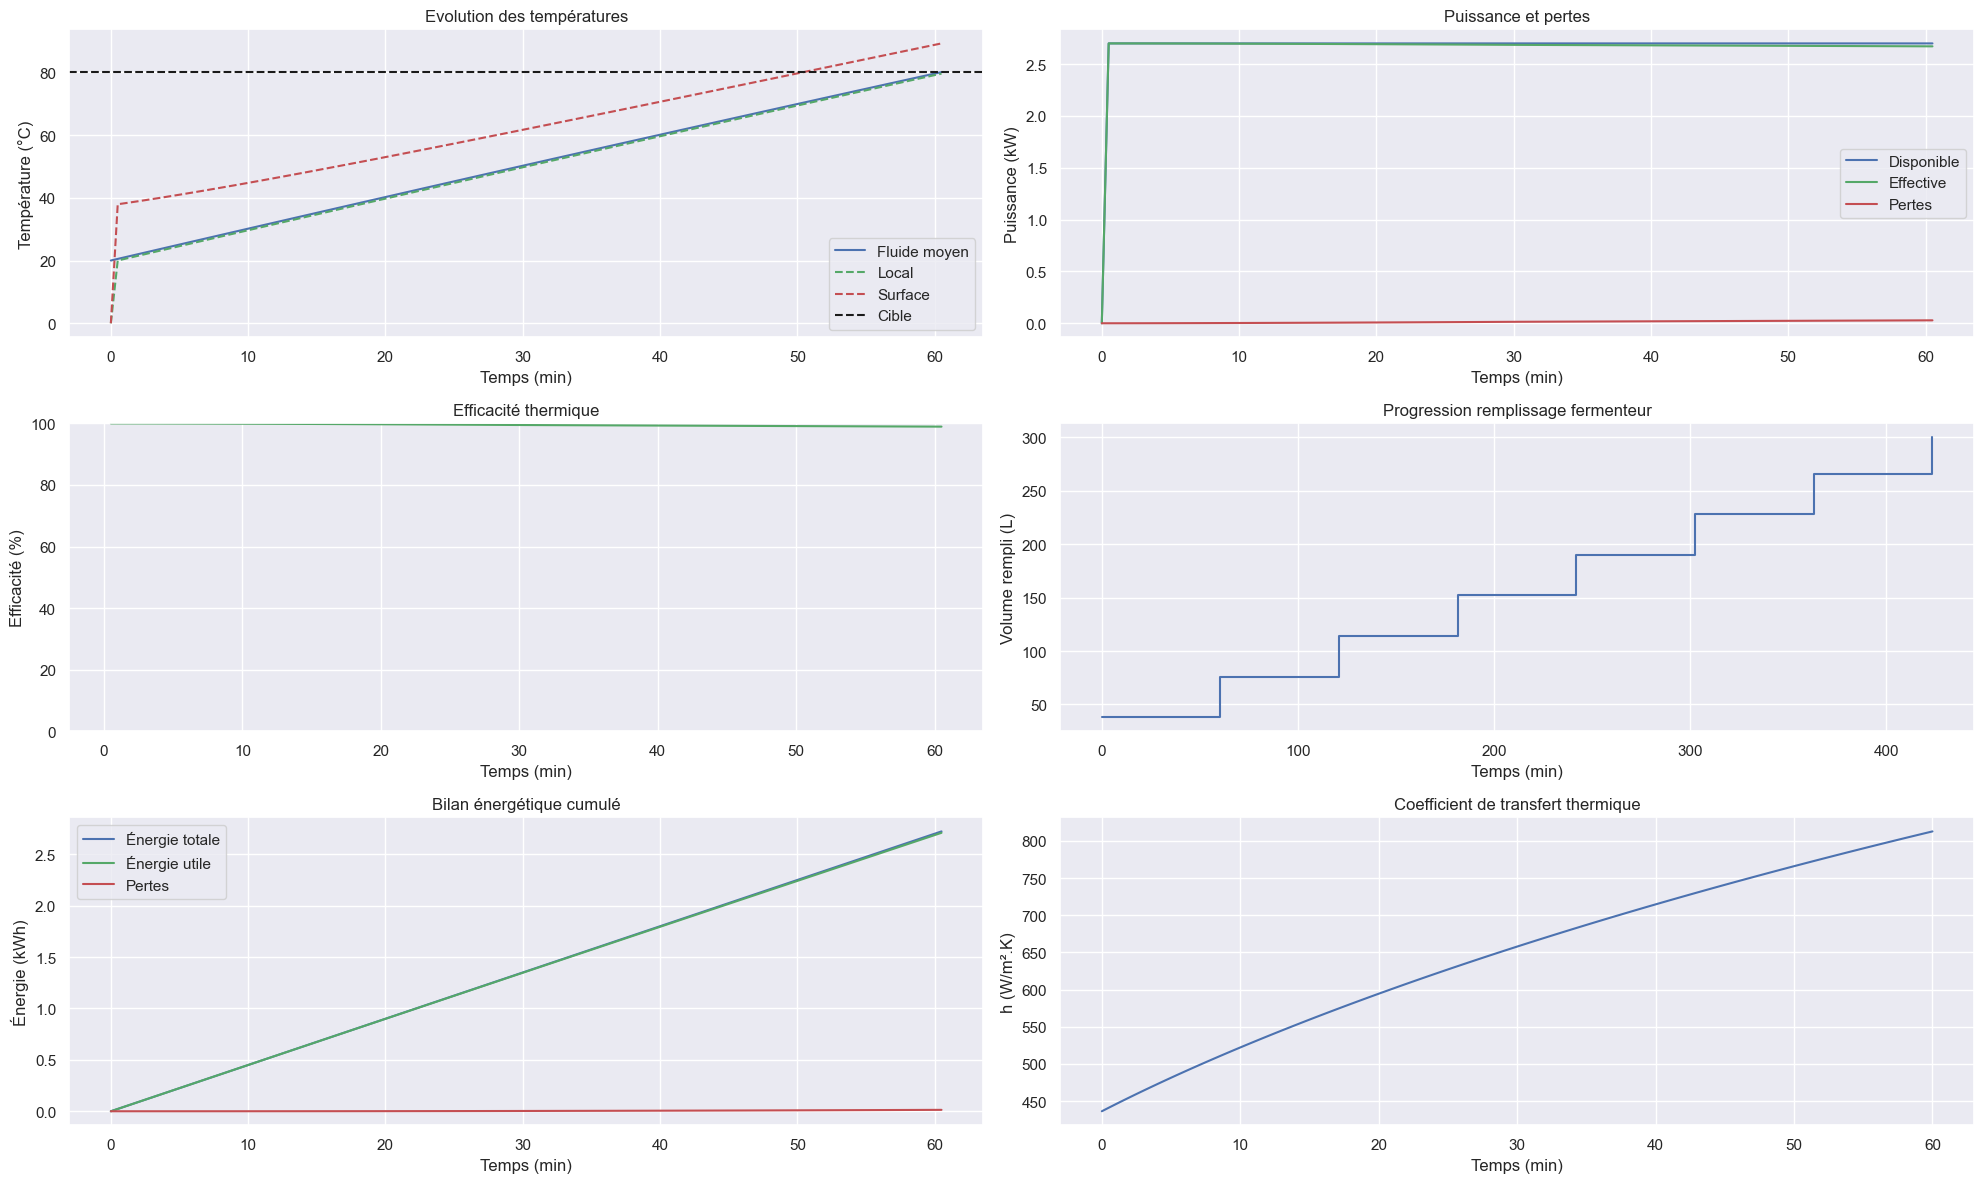

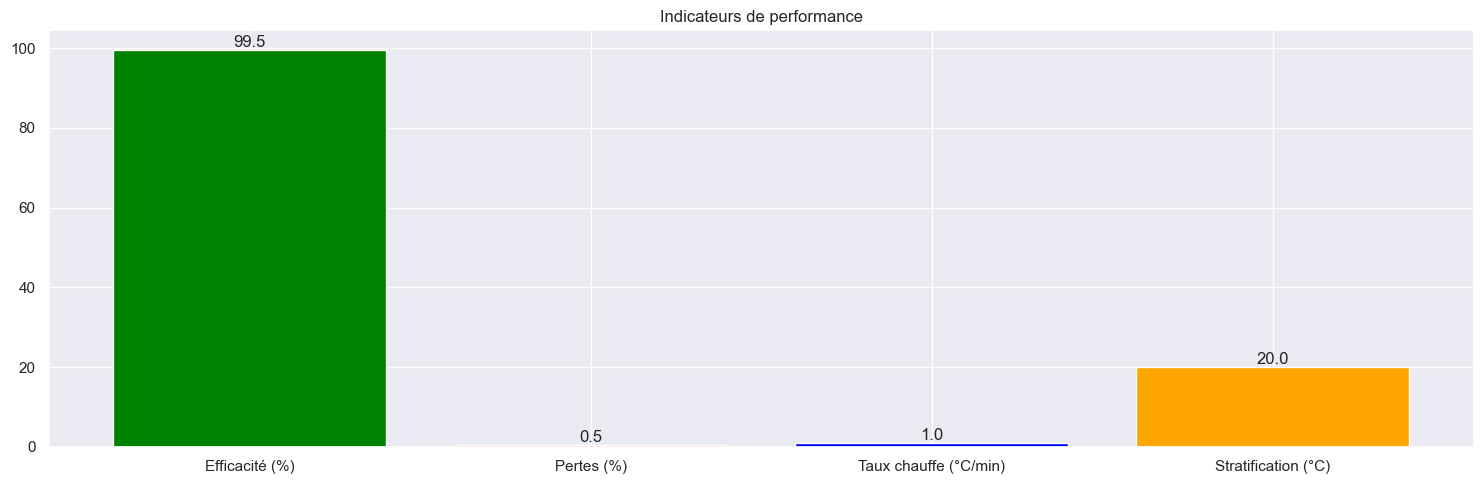

In [11]:
"""
III. ANALYSE DU CHAUFFAGE ÉLECTRIQUE
---------------------------------
Configuration:
- Tank chauffage: 38L avec résistance 3kW
- Fermenteur: 300L 
"""

# Imports standards
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any

# Imports depuis src
from src.equipment.tanks.bioreactor import TankGeometry, Bioreactor
from src.equipment.tanks.process_tank import ProcessTank
from src.equipment.heat_system.electrical_heater import ElectricalHeater, create_standard_heater
from src.process.thermal.heating import HeatingCalculator
from src.config import Config

# Configuration matplotlib
# plt.style.use('default') # plt.style.use('seaborn') #
sns.set_theme()  # Cela configurera automatiquement le style seaborn


# 1. Configuration des tanks
def setup_equipment():
    # Tank principal 38L avec résistance
    geometry_heat = TankGeometry(
        diameter=400,         # mm
        height_cylinder=400,  # mm
        height_total=600,     # mm
        volume_useful=38,     # L
        volume_cone=2,        # L
        volume_total=40       # L
    )

    tank_heat = ProcessTank(
        geometry=geometry_heat,
        tank_type='heating',
        material="316L",
        insulation_type="mineral_wool",
        insulation_thickness=25.0,  # mm
        design_temperature=95.0
    )

    # Fermenteur 300L
    geometry_ferm = TankGeometry(
        diameter=650,         # mm
        height_cylinder=900,  # mm
        height_total=1500,    # mm
        volume_useful=300,    # L
        volume_cone=20,       # L
        volume_total=320      # L
    )

    fermentor = Bioreactor(
        geometry=geometry_ferm,
        material="316L",
        insulation_type="mineral_wool",
        insulation_thickness=50.0,  # mm
        design_temperature=95.0
    )

    # Configuration résistance chauffante
    heater = create_standard_heater(3.0)  # 3kW standard

    return tank_heat, fermentor, heater

def print_equipment_info(tank_heat, fermentor, heater):
    print("\nA. Configuration équipements :")
    print("\n1. Tank chauffage:")
    print(f"Volume utile: {tank_heat.geometry.volume_useful}L")
    print(f"Surface d'échange: {tank_heat.geometry.surface_exchange:.2f} m²")

    print("\n2. Fermenteur:")
    print(f"Volume utile: {fermentor.geometry.volume_useful}L")
    print(f"Surface d'échange: {fermentor.geometry.surface_exchange:.2f} m²")

    print("\n3. Résistance chauffante:")
    print(f"Puissance: {heater.specs.power} kW")
    print(f"Surface: {heater.specs.surface:.2f} m²")
    print(f"Densité puissance: {heater.specs.power_density:.1f} kW/m²")

def run_heating_simulation(tank_heat, heater):
    heating_calc = HeatingCalculator(tank_heat)
    
    results_heating = heating_calc.calculate_electrical_heating_profile(
        heater=heater,
        temp_initial=20.0,     # °C
        temp_target=80.0,      # °C
        time_step=30,          # s
        detailed=True
    )
    
    return results_heating

def plot_heating_analysis(results_heating, tank_heat, fermentor):
    """
    Visualisation détaillée des résultats de simulation de chauffage
    Args:
        results_heating: résultats de la simulation
        tank_heat: tank de chauffe
        fermentor: fermenteur cible
    """
    if not results_heating:
        raise ValueError("Résultats de simulation vides")
        
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Evolution températures
    ax1 = plt.subplot(3, 2, 1)
    times = np.array(results_heating['times'])
    temps = np.array(results_heating['temperatures'])
    temp_local = np.array(results_heating['temp_local'])
    temp_surface = np.array(results_heating['temp_surface'])
    
    # Filtrer les valeurs NaN
    mask = ~np.isnan(temps) & ~np.isnan(temp_local) & ~np.isnan(temp_surface)
    ax1.plot(times[mask], temps[mask], 'b-', label='Fluide moyen')
    ax1.plot(times[mask], temp_local[mask], 'g--', label='Local')
    ax1.plot(times[mask], temp_surface[mask], 'r--', label='Surface')
    ax1.axhline(y=80, color='k', linestyle='--', label='Cible')
    ax1.grid(True)
    ax1.set_xlabel('Temps (min)')
    ax1.set_ylabel('Température (°C)')
    ax1.set_title('Evolution des températures')
    ax1.legend()

    # 2. Puissance et pertes
    ax2 = plt.subplot(3, 2, 2)
    power_available = np.array(results_heating['power_available'])
    power_out = np.array(results_heating['powers'])
    power_losses = np.array(results_heating['power_losses'])
    
    mask = ~np.isnan(power_available) & ~np.isnan(power_out) & ~np.isnan(power_losses)
    ax2.plot(times[mask], power_available[mask], 'b-', label='Disponible')
    ax2.plot(times[mask], power_out[mask], 'g-', label='Effective')
    ax2.plot(times[mask], power_losses[mask], 'r-', label='Pertes')
    ax2.grid(True)
    ax2.set_xlabel('Temps (min)')
    ax2.set_ylabel('Puissance (kW)')
    ax2.set_title('Puissance et pertes')
    ax2.legend()

    # 3. Efficacité thermique
    ax3 = plt.subplot(3, 2, 3)
    mask = power_available > 0
    efficiency = np.zeros_like(power_available)
    efficiency[mask] = (power_out[mask]/power_available[mask]) * 100
    ax3.plot(times[mask], efficiency[mask], 'g-')
    ax3.grid(True)
    ax3.set_xlabel('Temps (min)')
    ax3.set_ylabel('Efficacité (%)')
    ax3.set_title('Efficacité thermique')
    ax3.set_ylim([0, 100])

    # 4. Cycles de remplissage
    ax4 = plt.subplot(3, 2, 4)
    volume_ratio = fermentor.geometry.volume_useful / tank_heat.geometry.volume_useful
    n_cycles = int(np.ceil(volume_ratio))
    cycle_times = np.arange(n_cycles) * results_heating['duration']
    volume_filled = np.minimum(
        np.arange(1, n_cycles+1) * tank_heat.geometry.volume_useful, 
        fermentor.geometry.volume_useful
    )
    ax4.step(cycle_times, volume_filled, 'b-', where='post')
    ax4.grid(True)
    ax4.set_xlabel('Temps (min)')
    ax4.set_ylabel('Volume rempli (L)')
    ax4.set_title('Progression remplissage fermenteur')

    # 5. Bilan énergétique
    ax5 = plt.subplot(3, 2, 5)
    time_step = (times[1] - times[0]) * 60  # min -> sec
    dt = time_step/3600  # Conversion en heures
    energy_in = np.cumsum(power_available * dt)
    energy_out = np.cumsum(power_out * dt)
    energy_lost = np.cumsum(power_losses * dt)
    
    mask = ~np.isnan(energy_in) & ~np.isnan(energy_out) & ~np.isnan(energy_lost)
    ax5.plot(times[mask], energy_in[mask], 'b-', label='Énergie totale')
    ax5.plot(times[mask], energy_out[mask], 'g-', label='Énergie utile')
    ax5.plot(times[mask], energy_lost[mask], 'r-', label='Pertes')
    ax5.grid(True)
    ax5.set_xlabel('Temps (min)')
    ax5.set_ylabel('Énergie (kWh)')
    ax5.set_title('Bilan énergétique cumulé')
    ax5.legend()

    # 6. Coefficient de transfert thermique
    ax6 = plt.subplot(3, 2, 6)
    h_conv = np.array([d['heating']['h_conv'] for d in results_heating['evolution_data']])
    times_conv = times[:len(h_conv)]  # Ajuster les temps à la longueur de h_conv
    
    mask = ~np.isnan(h_conv)
    ax6.plot(times_conv[mask], h_conv[mask], 'b-')
    ax6.grid(True)
    ax6.set_xlabel('Temps (min)')
    ax6.set_ylabel('h (W/m².K)')
    ax6.set_title('Coefficient de transfert thermique')

    plt.tight_layout()
    return fig

def plot_performance_indicators(performance_metrics):
    """
    Affichage des indicateurs clés de performance
    Args:
        performance_metrics: métriques calculées
    """
    fig = plt.figure(figsize=(15, 5))

    # Sélection et filtrage des indicateurs
    indicators = {
        'Efficacité (%)': performance_metrics['thermal_efficiency'],
        'Pertes (%)': performance_metrics['heat_loss_ratio'],
        'Taux chauffe (°C/min)': performance_metrics['heating_rate'],
        'Stratification (°C)': performance_metrics['stratification_max']
    }
    
    # Filtrer les valeurs NaN ou infinies
    valid_indicators = {k: v for k, v in indicators.items() 
                       if not (np.isnan(v) or np.isinf(v))}

    if not valid_indicators:
        raise ValueError("Aucun indicateur valide à afficher")

    plt.bar(valid_indicators.keys(), valid_indicators.values(), 
            color=['green', 'red', 'blue', 'orange'])
    plt.grid(True, axis='y')
    plt.title('Indicateurs de performance')
    
    # Ajout des valeurs sur les barres
    for i, (key, value) in enumerate(valid_indicators.items()):
        plt.text(i, value, f'{value:.1f}', ha='center', va='bottom')

    plt.tight_layout()
    return fig

def main():
    # Setup equipment
    tank_heat, fermentor, heater = setup_equipment()
    
    # Print equipment info
    print_equipment_info(tank_heat, fermentor, heater)
    
    # Run simulation
    results_heating = run_heating_simulation(tank_heat, heater)
    
    try:
        # Plot analysis
        heating_fig = plot_heating_analysis(results_heating, tank_heat, fermentor)
        
        # Analyze performance
        performance_metrics = heater.analyze_performance(results_heating)
        
        # Get warnings
        warnings = heater.validate_performance(performance_metrics)
        
        # Plot performance indicators
        indicators_fig = plot_performance_indicators(performance_metrics)
        
        return {
            'results': results_heating,
            'performance': performance_metrics,
            'warnings': warnings,
            'figures': {
                'heating_analysis': heating_fig,
                'performance_indicators': indicators_fig
            }
        }
        
    except Exception as e:
        print(f"Erreur dans l'analyse : {str(e)}")
        return None

if __name__ == "__main__":
    results = main()
    if results:
        plt.show()  

In [12]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## IV - CIP - Chauffer un Tank de 38L avec 1 résistance thermique et lancer le CIP d'un Bioreacteur de 300L avec recirculation de l'eau (ves la résistance et le bioréacteur) 

## <span style="color:red">ERREURS DANS LES RESULTATS - CODE A CORRIGER/AMELIORER


Phase 1: Chauffe initiale du tank process

Phase 2: Recirculation (2.0 volumes)
- Volume réacteur: 300L
- Débit: 4.0m³/h
- Durée: 9.0min

Phase 1: Chauffe initiale du tank process

Phase 2: Recirculation (2.5 volumes)
- Volume réacteur: 300L
- Débit: 4.0m³/h
- Durée: 11.2min

Phase 1: Chauffe initiale du tank process

Phase 2: Recirculation (3.0 volumes)
- Volume réacteur: 300L
- Débit: 4.0m³/h
- Durée: 13.5min

Phase 1: Chauffe initiale du tank process

Phase 2: Recirculation (2.0 volumes)
- Volume réacteur: 300L
- Débit: 4.5m³/h
- Durée: 8.0min

Phase 1: Chauffe initiale du tank process

Phase 2: Recirculation (2.5 volumes)
- Volume réacteur: 300L
- Débit: 4.5m³/h
- Durée: 10.0min

Phase 1: Chauffe initiale du tank process

Phase 2: Recirculation (3.0 volumes)
- Volume réacteur: 300L
- Débit: 4.5m³/h
- Durée: 12.0min

Phase 1: Chauffe initiale du tank process

Phase 2: Recirculation (2.0 volumes)
- Volume réacteur: 300L
- Débit: 5.0m³/h
- Durée: 7.2min

Phase 1: Chauffe initiale du 

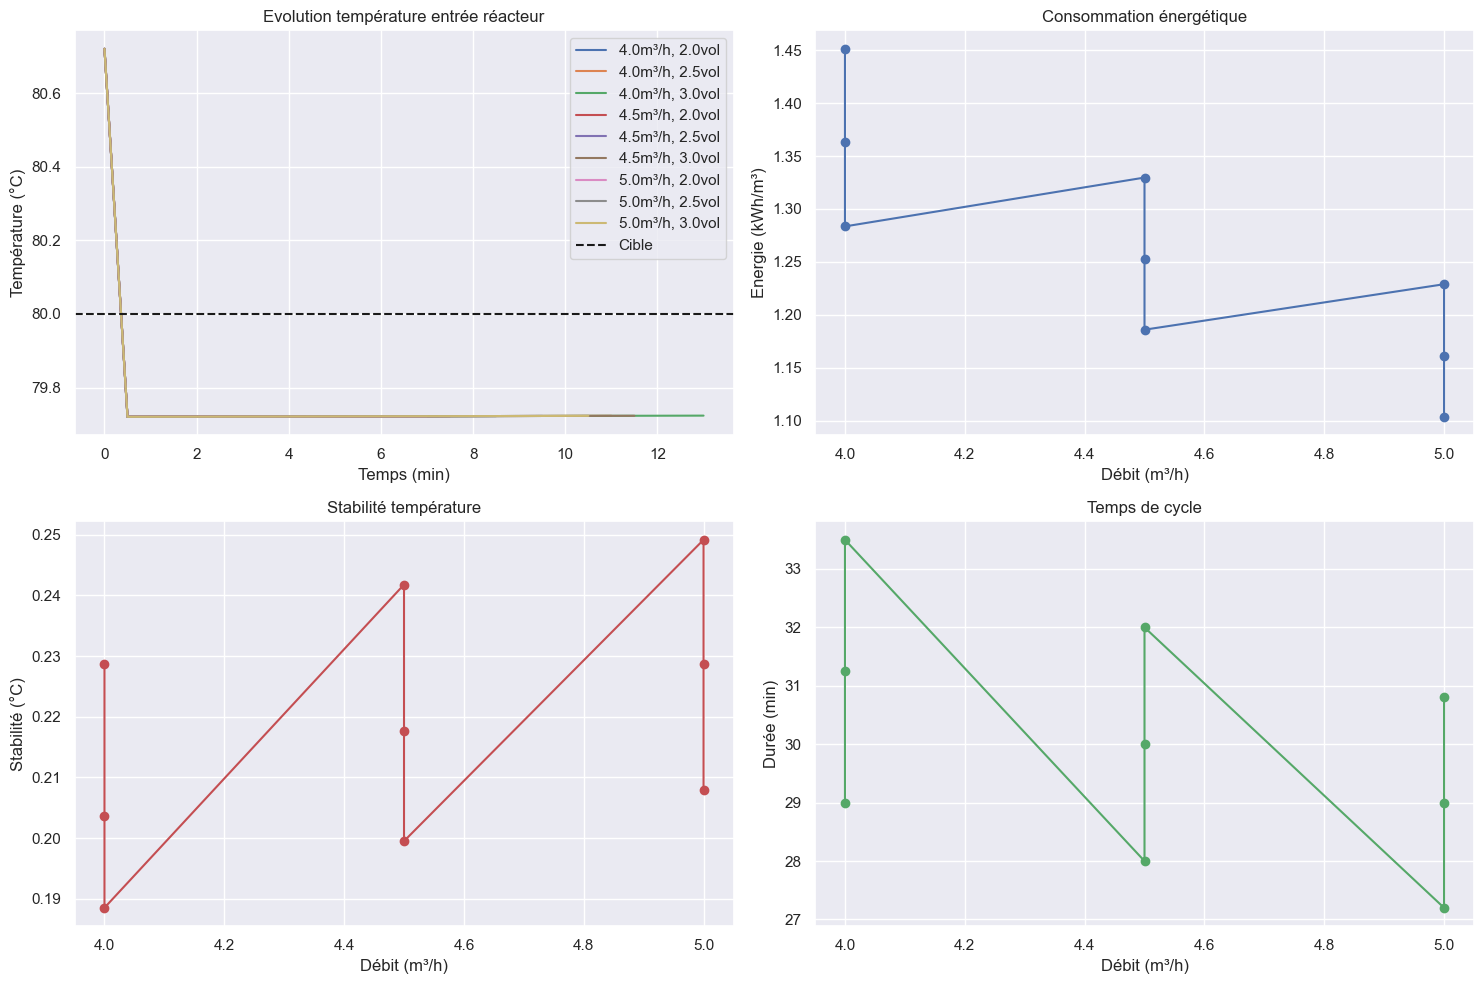

In [15]:
"""
ANALYSE OPTIMISÉE DU SYSTÈME CIP AVEC RECIRCULATION
Configuration :
- Tank process: 38L avec résistance 9kW
- Fermenteur: 300L avec boule de nettoyage
- Points de contrôle: T entrée fermenteur et T retour tank
"""

# src
import sys
import os
from typing import Dict, Tuple, Optional, Any

# Ajouter le chemin du projet au PYTHONPATH
project_path = os.path.abspath(os.path.join(os.getcwd(), 'E:\Programmation\GitHub\BIOREACTOR_DESIGN'))
if project_path not in sys.path:
    sys.path.append(project_path)
    

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.equipment.tanks.bioreactor import TankGeometry, Bioreactor
from src.equipment.tanks.process_tank import ProcessTank
from src.equipment.heat_system.electrical_heater import create_standard_heater
from src.process.thermal.cip_model import CIPThermalModel
from src.equipment.piping.pipeline import PipeSpecs
from src.process.thermal.thermal_utils import ThermalProperties
from src.config import Config

# 1. Configuration optimisée des équipements
def setup_optimized_equipment():
    # Tank process 38L avec isolation renforcée
    geometry_process = TankGeometry(
        diameter=400,         # mm
        height_cylinder=400,  # mm
        height_total=600,     # mm
        volume_useful=38,     # L
        volume_cone=2,        # L
        volume_total=40       # L
    )

    tank_process = ProcessTank(
        geometry=geometry_process,
        tank_type='heating',
        material="316L",
        insulation_type="mineral_wool",
        insulation_thickness=50.0,  # Augmenté à 50mm pour réduire les pertes
        design_temperature=95.0
    )

    # Fermenteur 300L avec isolation standard
    geometry_ferm = TankGeometry(
        diameter=650,         # mm
        height_cylinder=900,  # mm 
        height_total=1500,   # mm
        volume_useful=300,   # L
        volume_cone=20,      # L
        volume_total=320     # L
    )

    fermentor = Bioreactor(
        geometry=geometry_ferm,
        material="316L",
        insulation_type="mineral_wool",
        insulation_thickness=50.0,
        design_temperature=95.0
    )

    # Résistance 9kW avec régulation PID
    heater = create_standard_heater(9.0)

    # Tuyauterie optimisée avec isolation renforcée
    pipe_specs = {
        'supply': PipeSpecs(
            diameter=25.4,    # DN25
            length=5.0,       # m
            thickness=2.0,    # mm
            insulation_type='mineral_wool',
            insulation_thickness=50.0  # Augmenté pour réduire les pertes
        ),
        'return': PipeSpecs(
            diameter=25.4,
            length=5.0,
            thickness=2.0,
            insulation_type='mineral_wool',
            insulation_thickness=50.0
        )
    }

    return tank_process, fermentor, heater, pipe_specs

# 2. Configuration test optimisée selon standards BPF
def get_test_configurations():
    return {
        'flow_rates': [4.0, 4.5, 5.0],  # m³/h
        'n_volumes': [2.0, 2.5, 3.0],   # Nombres de volumes à recirculer
        'temp_target': 80.0,            # °C
        'pressure': 4.0,                # bar (minimum requis pour CIP selon Config.py)
        'time_step': 1.0                # s
    }

# 3. Fonction d'analyse des résultats
def analyze_cip_results(results, config):
    """Analyse détaillée des résultats CIP"""
    
    # Extraction métriques clés
    perf = results['performance']
    temps_final = results['final_temps']
    
    # Calcul métriques énergétiques
    volume_total = config['flow_rate'] * (results['total_duration']/60)  # m³
    energy_per_m3 = results['total_energy'] / volume_total  # kWh/m³
    
    # Analyse stabilité température
    temp_data = np.array(results['cip_phase']['temps_reactor_inlet'])
    temp_stability = np.std(temp_data)
    temp_range = np.max(temp_data) - np.min(temp_data)
    
    # Validation des critères CIP
    temp_ok = temps_final['reactor_inlet'] >= config['temp_target'] - 2
    time_ok = results['total_duration'] >= 20  # min selon BPF
    stability_ok = temp_stability <= 1.0  # °C
    
    return {
        'energy_metrics': {
            'total_energy': results['total_energy'],
            'energy_per_m3': energy_per_m3,
            'average_power': np.mean(results['cip_phase']['powers'])
        },
        'temperature_metrics': {
            'final_temp': temps_final['reactor_inlet'],
            'stability': temp_stability,
            'range': temp_range
        },
        'validation': {
            'temp_ok': temp_ok,
            'time_ok': time_ok,
            'stability_ok': stability_ok,
            'all_ok': temp_ok and time_ok and stability_ok
        }
    }

# 4. Fonction principale de test
def run_optimized_cip_analysis():
    # Setup equipment
    tank, fermentor, heater, pipes = setup_optimized_equipment()
    
    # Create CIP model
    cip_model = CIPThermalModel(
        tank_process=tank,
        reactor=fermentor,
        heater=heater,
        pipe_specs=pipes
    )
    
    # Get test configurations
    test_configs = get_test_configurations()
    
    results_matrix = []
    
    # Test all combinations
    for flow_rate in test_configs['flow_rates']:
        for n_vol in test_configs['n_volumes']:
            config = {
                'flow_rate': flow_rate,
                'n_volumes': n_vol,
                'temp_target': test_configs['temp_target'],
                'pressure': test_configs['pressure'],
                'detailed': True
            }
            
            # Run simulation
            results = cip_model.calculate_cip_cycle(**config)
            
            # Analyze results
            analysis = analyze_cip_results(results, config)
            
            results_matrix.append({
                'config': config,
                'results': results,
                'analysis': analysis
            })
            
    return results_matrix

# 5. Visualisation des résultats
def plot_cip_analysis(results_matrix):
    plt.figure(figsize=(15, 10))
    
    # 1. Température vs Temps pour chaque config
    plt.subplot(2, 2, 1)
    for result in results_matrix:
        config = result['config']
        temps = np.array(result['results']['cip_phase']['temps_reactor_inlet'])
        times = np.array(result['results']['cip_phase']['times'])
        label = f"{config['flow_rate']}m³/h, {config['n_volumes']}vol"
        plt.plot(times, temps, label=label)
    
    plt.axhline(y=80, color='k', linestyle='--', label='Cible')
    plt.grid(True)
    plt.xlabel('Temps (min)')
    plt.ylabel('Température (°C)')
    plt.title('Evolution température entrée réacteur')
    plt.legend()
    
    # 2. Consommation énergétique
    plt.subplot(2, 2, 2)
    flow_rates = [r['config']['flow_rate'] for r in results_matrix]
    energies = [r['analysis']['energy_metrics']['energy_per_m3'] for r in results_matrix]
    plt.plot(flow_rates, energies, 'bo-')
    plt.grid(True)
    plt.xlabel('Débit (m³/h)')
    plt.ylabel('Energie (kWh/m³)')
    plt.title('Consommation énergétique')
    
    # 3. Stabilité température
    plt.subplot(2, 2, 3)
    stabilities = [r['analysis']['temperature_metrics']['stability'] for r in results_matrix]
    plt.plot(flow_rates, stabilities, 'ro-')
    plt.grid(True)
    plt.xlabel('Débit (m³/h)')
    plt.ylabel('Stabilité (°C)')
    plt.title('Stabilité température')
    
    # 4. Temps de cycle
    plt.subplot(2, 2, 4)
    durations = [r['results']['total_duration'] for r in results_matrix]
    plt.plot(flow_rates, durations, 'go-')
    plt.grid(True)
    plt.xlabel('Débit (m³/h)')
    plt.ylabel('Durée (min)')
    plt.title('Temps de cycle')
    
    plt.tight_layout()
    
    return plt.gcf()

# 6. Execution des tests
results_matrix = run_optimized_cip_analysis()
fig = plot_cip_analysis(results_matrix)

# 7. Analyse des résultats
print("\nRésultats optimisation CIP:")
print("-" * 50)

best_configs = {
    'energy': min(results_matrix, key=lambda x: x['analysis']['energy_metrics']['energy_per_m3']),
    'stability': min(results_matrix, key=lambda x: x['analysis']['temperature_metrics']['stability']),
    'time': min(results_matrix, key=lambda x: x['results']['total_duration'])
}

for metric, result in best_configs.items():
    config = result['config']
    analysis = result['analysis']
    
    print(f"\nMeilleure configuration pour {metric}:")
    print(f"- Débit: {config['flow_rate']} m³/h")
    print(f"- Volumes: {config['n_volumes']}")
    print(f"- Energie: {analysis['energy_metrics']['energy_per_m3']:.3f} kWh/m³")
    print(f"- Stabilité: ±{analysis['temperature_metrics']['stability']:.1f}°C")
    print(f"- Durée: {result['results']['total_duration']:.1f} min")

# 8. Validation finale
valid_configs = [r for r in results_matrix if r['analysis']['validation']['all_ok']]
if valid_configs:
    best_valid = min(valid_configs, 
                    key=lambda x: x['analysis']['energy_metrics']['energy_per_m3'])
    
    print("\nConfiguration optimale recommandée:")
    print(f"- Débit: {best_valid['config']['flow_rate']} m³/h")
    print(f"- Volumes: {best_valid['config']['n_volumes']}")
    print(f"- Energie: {best_valid['analysis']['energy_metrics']['energy_per_m3']:.3f} kWh/m³")
    print(f"- Stabilité: ±{best_valid['analysis']['temperature_metrics']['stability']:.1f}°C")
    print(f"- Durée: {best_valid['results']['total_duration']:.1f} min")
else:
    print("\nAucune configuration ne satisfait tous les critères!")